# Calibration #

In [1]:
# %% Imports

import os
import re
import time
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import fabio
import pyFAI
from pyFAI.gui import jupyter
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.geometry import Geometry
from pyFAI.goniometer import SingleGeometry


try:
    from zoneinfo import ZoneInfo  # Python 3.9+
except ImportError:
    from backports.zoneinfo import ZoneInfo  # if needed

import ipywidgets as widgets
from IPython.display import display

%matplotlib inline

print(f"Using pyFAI version: {pyFAI.version}")


Using pyFAI version: 2024.9.0


In [2]:
# %% Define calibrant directory and ensure it exists

calib_dir = r"C:\Users\zhihe\OneDrive - Stanford\BL11-3_Demo\Calibrant"

if not os.path.isdir(calib_dir):
    raise FileNotFoundError(f"Calibrant directory does not exist: {calib_dir}")

print(f"Calibrant directory found: {calib_dir}")


Calibrant directory found: C:\Users\zhihe\OneDrive - Stanford\BL11-3_Demo\Calibrant


In [3]:
# %% Find calibrant candidates (paired .tif/.tiff + .txt) and select via dropdown

all_files = os.listdir(calib_dir)
tiff_exts = (".tif", ".tiff")

tiff_basenames = {
    os.path.splitext(f)[0]
    for f in all_files
    if f.lower().endswith(tiff_exts)
}
txt_basenames = {
    os.path.splitext(f)[0]
    for f in all_files
    if f.lower().endswith(".txt")
}

calib_names = sorted(tiff_basenames & txt_basenames)

if not calib_names:
    raise RuntimeError("No matching .tif/.tiff + .txt pairs found!")

dropdown = widgets.Dropdown(
    options=calib_names,
    description="Calibrant:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="300px"),
)

display(dropdown)


Dropdown(description='Calibrant:', layout=Layout(width='300px'), options=('LaB6_150mm_07171857_0001', 'LaB6_15…

Selected calibrant: LaB6_150mm_07171857_0001
Image file: C:\Users\zhihe\OneDrive - Stanford\BL11-3_Demo\Calibrant\LaB6_150mm_07171857_0001.tif
Metadata file: C:\Users\zhihe\OneDrive - Stanford\BL11-3_Demo\Calibrant\LaB6_150mm_07171857_0001.txt


<Axes: >

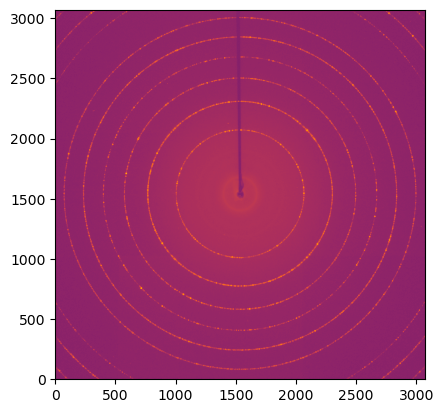

In [4]:
# %% Load selected 2D image and metadata text file

calib_name = dropdown.value
print(f"Selected calibrant: {calib_name}")

# Find .tif/.tiff image
image_file = None
for ext in tiff_exts:
    p = os.path.join(calib_dir, calib_name + ext)
    if os.path.isfile(p):
        image_file = p
        break

if image_file is None:
    raise FileNotFoundError(f"No tif/tiff image found for {calib_name}")

txt_path = os.path.join(calib_dir, calib_name + ".txt")

print(f"Image file: {image_file}")
print(f"Metadata file: {txt_path}")

# Load 2D scattering image
calib_img = fabio.open(image_file).data

# quick view
jupyter.display(calib_img)


In [5]:
# In parse_metadata_file() docstring and notes, add:
# Motors (all in mm):
#   detx, dety = offsets in mm relative to nominal detector center
#   detz       = sample–detector distance in mm

def parse_metadata_file(txt_path, timezone="America/Los_Angeles"):
    """
    Parse BL11-3 style metadata file.

    Extracts:
      - user
      - local datetime (with timezone)
      - UNIX time (seconds since epoch)
      - sample temperature (C)
      - counters (full dict)
      - motors (full dict)

    Notes
    -----
    * Counters:
        Uses 'sec', 'Monitor', 'bstop'/'Bstop', 'I0' as important
        measuring parameters (exposure time and monitor counts).

    * Motors:
        Currently we only *use* detx, dety, detz for a simple
        transmission geometry (beam center and sample–detector distance).
        The parser still reads all motors into a dictionary.

        For **mapping measurements**, more motor positions (e.g. samx/samy,
        stage translations, rotation motors, etc.) will need to be read
        and used downstream to reconstruct the scan grid or sample position.

        For **grazing-incidence measurements (GISAXS/GIWAXS)**, the geometry
        is more complicated (incident angle, sample tilt, possible detector
        tilt/rotation, etc.) and additional motors must be interpreted
        consistently with the chosen geometry model (e.g. pyFAI goniometer).
    """
    with open(txt_path, "r") as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    meta = {}

    # --- User + timestamp ---
    user_line = next(l for l in lines if l.lower().startswith("user:"))
    m = re.match(r"User:\s*(?P<user>[^,]+),\s*time:\s*(?P<time>.+)", user_line)

    user = m.group("user")
    dt_naive = datetime.strptime(m.group("time"), "%a %b %d %H:%M:%S %Y")
    dt_local = dt_naive.replace(tzinfo=ZoneInfo(timezone))
    meta["user"] = user
    meta["datetime_local"] = dt_local
    meta["unix_time"] = dt_local.timestamp()

    # --- Temperature ---
    temp_line = next(l for l in lines if l.endswith("C") and not l.startswith("#"))
    temperature_C = float(re.search(r"([-+]?\d*\.\d+|\d+)", temp_line).group())
    meta["temperature_C"] = temperature_C

    # --- Counters ---
    counters_idx = next(i for i,l in enumerate(lines) if l.startswith("# Counters"))
    counters_line = lines[counters_idx + 1]

    counters = {}
    for part in counters_line.split(","):
        if "=" in part:
            k, v = part.split("=")
            try:
                counters[k.strip()] = float(v)
            except:
                counters[k.strip()] = v

    meta["counters"] = counters
    meta["measure_important"] = {
        "sec": counters.get("sec"),
        "Monitor": counters.get("Monitor"),
        "Bstop": counters.get("bstop") or counters.get("Bstop"),
        "I0": counters.get("I0"),
    }

    # --- Motors ---
    motors_idx = next(i for i,l in enumerate(lines) if l.startswith("# Motors"))
    motors_line = lines[motors_idx + 1]

    motors = {}
    for part in motors_line.split(","):
        if "=" in part:
            k,v = part.split("=")
            motors[k.strip()] = float(v)

    meta["motors"] = motors
    meta["geometry_transmission"] = {
        "detx": motors.get("detx"),
        "dety": motors.get("dety"),
        "detz": motors.get("detz"),
    }

    return meta



In [6]:
# %% Use the parser on the selected txt_path
meta = parse_metadata_file(txt_path)

print("User:", meta["user"])
print("Local datetime:", meta["datetime_local"])
print("UNIX time (s):", meta["unix_time"])
print("Temperature (C):", meta["temperature_C"])
print("\nImportant measuring parameters:")
for k, v in meta["measure_important"].items():
    print(f"  {k}: {v}")

print("\nImportant transmission geometry params (detx, dety, detz):")
for k, v in meta["geometry_transmission"].items():
    print(f"  {k}: {v}")

User: b_stone
Local datetime: 2022-07-17 18:57:21-07:00
UNIX time (s): 1658109441.0
Temperature (C): 30.7

Important measuring parameters:
  sec: 5.0
  Monitor: 567016.0
  Bstop: 181114.0
  I0: 580385.0

Important transmission geometry params (detx, dety, detz):
  detx: 22.75
  dety: -126.2
  detz: 150.002


In [13]:
# %% Set up energy, calibrant, detector, wavelength, geometry

energy_keV = 12.7
wavelength_A = 12.39842 / energy_keV
wavelength_m = wavelength_A * 1e-10

print(f"Wavelength: {wavelength_A:.6f} Å")

calibrant_name = "LaB6"
calibrant = CALIBRANT_FACTORY(calibrant_name)

detector_name = "Rayonix MX225"
Rayonix = pyFAI.detector_factory(detector_name)

px_size_y_mm = Rayonix.pixel1 * 1000  # vertical pixel size (m -> mm)
px_size_x_mm = Rayonix.pixel2 * 1000  # horizontal pixel size (m -> mm)

print("Detector:", detector_name)
print(f"Pixel size (mm): y = {px_size_y_mm:.4f}, x = {px_size_x_mm:.4f}")

mot = meta["geometry_transmission"]
detx_mm = mot["detx"]   # detector shift in mm
dety_mm = mot["dety"]
detz_mm = mot["detz"]   # sample–detector distance in mm

print(f"detx = {detx_mm} mm, dety = {dety_mm} mm, detz = {detz_mm} mm")

# --- nominal beam center (in mm), then convert to pixels ---
nominal_cx_mm = 112.5
nominal_cy_mm = 112.5

nominal_cx_pix = nominal_cx_mm / px_size_x_mm
nominal_cy_pix = nominal_cy_mm / px_size_y_mm

print(f"Nominal beam center from mm → px: "
      f"({nominal_cx_pix:.2f}, {nominal_cy_pix:.2f})")


print(f"Initial beam center estimate (px): ({nominal_cx_pix:.2f}, {nominal_cy_pix:.2f})")

# SDD in meters (pyFAI uses m for distance)
sdd_m = detz_mm * 1e-3
print(f"Sample–detector distance: {detz_mm:.2f} mm → {sdd_m:.4f} m")


Wavelength: 0.976254 Å
Detector: Rayonix MX225
Pixel size (mm): y = 0.0732, x = 0.0732
detx = 22.75 mm, dety = -126.2 mm, detz = 150.002 mm
Nominal beam center from mm → px: (1536.00, 1536.00)
Initial beam center estimate (px): (1536.00, 1536.00)
Sample–detector distance: 150.00 mm → 0.1500 m


In [14]:
better_estimation_detz_mm = 160.0 # 150 from detz is still to far away from real number to make the refinement converge

In [15]:
# %% Calibration with SingleGeometry on selected calibrant image (transmission)

os.chdir(calib_dir)

frame = calib_img

tilt = 0

# Set the guessed geometry
initial = pyFAI.geometry.Geometry(detector=Rayonix, wavelength=wavelength_m)
initial.setFit2D(better_estimation_detz_mm,nominal_cx_pix,nominal_cy_pix,tilt)

Detector Rayonix MX225	 PixelSize= 7.324e-05, 7.324e-05 m	 BottomRight (3)
Wavelength= 9.762535e-11 m
SampleDetDist= 1.620000e-01 m	PONI= 1.125000e-01, 1.125000e-01 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 162.000 mm	Center: x=1536.004, y=1536.004 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.976Å

In [20]:
# The SingleGeometry object (from goniometer) allows to extract automatically ring and calibrate

max_rings = 9

sg = SingleGeometry(image_file, frame, calibrant=calibrant, detector=Rayonix, geometry=initial)
sg.extract_cp(max_rings=max_rings)

ControlPoints instance containing 9 group of point:
LaB6 Calibrant with 61 reflections at wavelength 9.762535433070867e-11
Containing 9 groups of points:
# g ring 0: 361 points
# h ring 1: 361 points
# i ring 2: 361 points
# j ring 3: 361 points
# k ring 4: 361 points
# l ring 5: 361 points
# m ring 6: 124 points
# n ring 7: 60 points
# o ring 8: 20 points

Text(0.5, 1.0, 'LaB6_150mm_07171857_0001.tif')

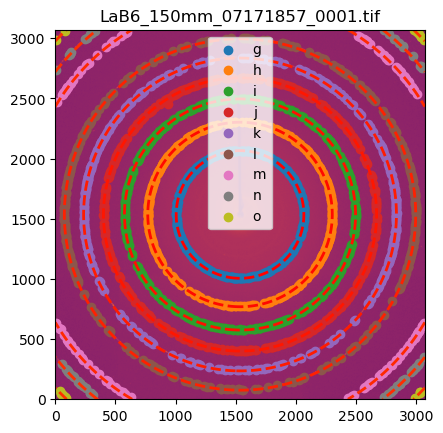

In [21]:
# --- 4) Show calibration overlay ---
ax = jupyter.display(sg=sg)
ax.set_title(os.path.basename(image_file))


In [22]:
# Refine the geometry
for _ in range(3):
    sg.geometry_refinement.refine2(fix=["wavelength"])



In [23]:
# %% Print full calibrated PONI content

ai = sg.get_ai()   # AzimuthalIntegrator from calibrated geometry

print("\n==================== Calibrated PONI ====================")
print(f"dist    = {ai.dist:.6f}   # meters")
print(f"poni1   = {ai.poni1:.6f}  # meters")
print(f"poni2   = {ai.poni2:.6f}  # meters")
print(f"rot1    = {ai.rot1:.6f}   # radians")
print(f"rot2    = {ai.rot2:.6f}   # radians")
print(f"rot3    = {ai.rot3:.6f}   # radians")

print(f"pixel1  = {ai.pixel1:.9f}  # pixel size vertical (m)")
print(f"pixel2  = {ai.pixel2:.9f}  # pixel size horizontal (m)")
print(f"wavelength = {ai.wavelength:.9e}  # meters")

# Detector info
print(f"detector = {ai.detector.name}")

# Optional: full PONI-formatted block
print("\n# -------- PONI file block (copy/paste-ready) --------")
print(f"Detector: {ai.detector.name}")
print(f"PixelSize1: {ai.pixel1}")
print(f"PixelSize2: {ai.pixel2}")
print(f"Distance: {ai.dist}")
print(f"Poni1: {ai.poni1}")
print(f"Poni2: {ai.poni2}")
print(f"Rot1: {ai.rot1}")
print(f"Rot2: {ai.rot2}")
print(f"Rot3: {ai.rot3}")
print(f"Wavelength: {ai.wavelength}")
print("========================================================\n")



==================== Calibrated PONI ====================
dist    = 0.161942   # meters
poni1   = 0.112119  # meters
poni2   = 0.112599  # meters
rot1    = 0.000310   # radians
rot2    = 0.003070   # radians
rot3    = -0.000000   # radians
pixel1  = 0.000073242  # pixel size vertical (m)
pixel2  = 0.000073242  # pixel size horizontal (m)
wavelength = 9.762535433e-11  # meters
detector = Rayonix MX225

# -------- PONI file block (copy/paste-ready) --------
Detector: Rayonix MX225
PixelSize1: 7.3242e-05
PixelSize2: 7.3242e-05
Distance: 0.16194207723801413
Poni1: 0.11211902877200136
Poni2: 0.11259921324528402
Rot1: 0.00031012192513274933
Rot2: 0.003069785849768497
Rot3: -1.2772298106883745e-09
Wavelength: 9.762535433070867e-11



In [24]:
# %% Save calibrated PONI file using selected image name

# strip extension from the selected image file
base_name = os.path.splitext(os.path.basename(image_file))[0]

poni_path = os.path.join(calib_dir, base_name + ".poni")

# save calibrated geometry into the PONI file
sg.geometry_refinement.save(poni_path)

print("Calibrated PONI saved as:")
print("  ", poni_path)

# show contents of the file
print("\n=========== PONI FILE CONTENTS ===========")
with open(poni_path, "r") as f:
    print(f.read())
print("==========================================")


Calibrated PONI saved as:
   C:\Users\zhihe\OneDrive - Stanford\BL11-3_Demo\Calibrant\LaB6_150mm_07171857_0001.poni

=========== PONI FILE CONTENTS ===========
# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis
# Calibration done on Mon Dec  8 17:43:01 2025
poni_version: 2.1
Detector: RayonixMx225
Detector_config: {"pixel1": 7.3242e-05, "pixel2": 7.3242e-05, "orientation": 3}
Distance: 0.16194207723801413
Poni1: 0.11211902877200136
Poni2: 0.11259921324528402
Rot1: 0.00031012192513274933
Rot2: 0.003069785849768497
Rot3: -1.2772298106883745e-09
Wavelength: 9.762535433070867e-11



### in summary, calibration by scripts need a very good estimation of original beamcenter and sample-detector distance ###

### this is just the script for reference. I would strongly recommand do calibration and masking by pyFAI-calib2 ###

# Integration #

In [27]:
# %% Set data directory (for integration) and mask file

# Directory containing your raw 2D data to integrate
data_dir = r"C:\Users\zhihe\OneDrive - Stanford\BL11-3_Demo\X_Data"  # <-- EDIT THIS
if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"Data directory does not exist: {data_dir}")
print("Data directory:", data_dir)

# Use the PONI we just saved during calibration
# (poni_path was defined in the calibration section)
print("Using PONI:", poni_path)

# Mask file (EDF). Put the mask where you like and point to it here.
mask_path = r"C:\Users\zhihe\OneDrive - Stanford\BL11-3_Demo\mask.edf"  # <-- EDIT THIS
if not os.path.isfile(mask_path):
    raise FileNotFoundError(f"Mask file not found: {mask_path}")
print("Mask file:", mask_path)

Data directory: C:\Users\zhihe\OneDrive - Stanford\BL11-3_Demo\X_Data
Using PONI: C:\Users\zhihe\OneDrive - Stanford\BL11-3_Demo\Calibrant\LaB6_150mm_07171857_0001.poni
Mask file: C:\Users\zhihe\OneDrive - Stanford\BL11-3_Demo\mask.edf


In [28]:
# %% Load integrator from PONI and apply EDF mask

#Edit here if another .poni will be used

# Load calibrated geometry
ai = pyFAI.load(poni_path)

print("\nLoaded PONI geometry:")
print(f"  dist  = {ai.dist*1000:.3f} mm")
print(f"  poni1 = {ai.poni1*1000:.3f} mm")
print(f"  poni2 = {ai.poni2*1000:.3f} mm")

# Load mask (EDF)
mask_raw = fabio.open(mask_path).data
# pyFAI expects a boolean mask: True = masked, False = valid
mask = mask_raw != 0

ai.set_mask(mask)
print("Mask applied. Shape:", mask.shape)



Loaded PONI geometry:
  dist  = 161.942 mm
  poni1 = 112.119 mm
  poni2 = 112.599 mm
Mask applied. Shape: (3072, 3072)


In [29]:
# %% Helper: list images in data_dir

def list_images(dir_path, exts=(".tif", ".tiff")):
    files = [
        f for f in os.listdir(dir_path)
        if f.lower().endswith(exts)
    ]
    files.sort()
    return files

image_files = list_images(data_dir)
print(f"Found {len(image_files)} images for integration.")
for f in image_files[:5]:
    print("  ", f)


Found 3 images for integration.
   mbp54E_Cby3_0001.tif
   mbp54E_Cby3_0002.tif
   mbp54E_Cby3_0003.tif


## important parameters from the metadata file would be read and stored in this matrix ##

In [42]:
# %% Integrate all images to 1D and store results (2θ, accurate method)

npt = 2500  # number of bins
integration_results = []

# pull important metadata once
measure_params = meta["measure_important"]
geom_params    = meta["geometry_transmission"]

for fname in image_files:
    fpath = os.path.join(data_dir, fname)
    frame = fabio.open(fpath).data
    
    # high-accuracy 1D integration in 2θ
    two_theta, I, err = ai.integrate1d(
        frame,
        npt,
        unit="2th_deg",
        method="bbox",       # or "numpy" for maximum accuracy
        mask=mask,
        error_model="poisson"
    )
    
    # append results + metadata
    integration_results.append({
        "file": fname,
        "two_theta": two_theta,
        "I": I,
        "err": err,

        # measurement parameters
        "measure_sec": measure_params.get("sec"),
        "measure_monitor": measure_params.get("Monitor"),
        "measure_bstop": measure_params.get("Bstop"),
        "measure_I0": measure_params.get("I0"),

        # geometry (motor) parameters
        "mot_detx": geom_params.get("detx"),
        "mot_dety": geom_params.get("dety"),
        "mot_detz": geom_params.get("detz"),
    })

print(f"Integrated {len(integration_results)} images with metadata added.")


Integrated 3 images with metadata added.


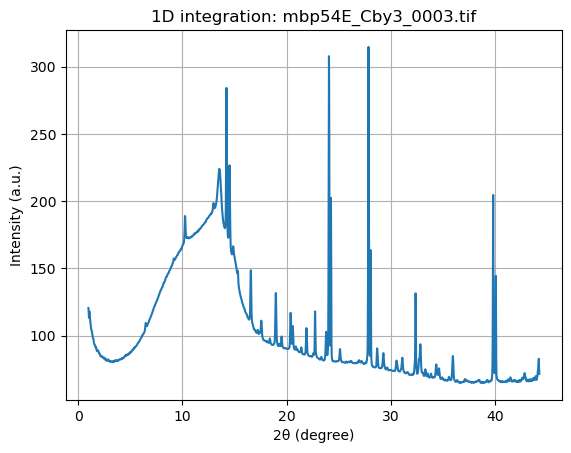

In [43]:
# %% Plot an example integrated pattern

idx = 2  # choose which pattern to view
r = integration_results[idx]

plt.figure()
plt.plot(r["two_theta"], r["I"])
plt.xlabel("2θ (degree)")
plt.ylabel("Intensity (a.u.)")
plt.title(f"1D integration: {r['file']}")
plt.grid(True)
plt.show()


In [45]:
# %% Save all integrated patterns as XYE files

out_dir = os.path.join(data_dir, "integrated_XYE")
os.makedirs(out_dir, exist_ok=True)

print("Saving XYE files to:", out_dir)

for r in integration_results:
    base = os.path.splitext(r["file"])[0]   # e.g., myimage_0001 → myimage_0001
    out_path = os.path.join(out_dir, base + ".xye")

    # X Y E columns: 2θ (deg), intensity, error
    xye_arr = np.column_stack([r["two_theta"], r["I"], r["err"]])

    np.savetxt(
        out_path,
        xye_arr,
        fmt="%.7f",
        header="2theta(deg)    Intensity    Error",
    )

print("Finished writing", len(integration_results), "XYE files.")


Saving XYE files to: C:\Users\zhihe\OneDrive - Stanford\BL11-3_Demo\X_Data\integrated_XYE
Finished writing 3 XYE files.
